# Capstone Project: UK Immigration/Asylum Analysis (2001-2023)

## Book 3: Pre-Processing

Author: Patrick Smith

Date: 16/04/2024

Contact: patrick.b.smith@gmail.com

         *                 *                  *              *
                                                      *             *
                        *            *                             ___
  *               *                                          |     | |
        *              _________##                 *        / \    | |
                      @\\\\\\\\\##    *     |              |--o|===|-|
  *                  @@@\\\\\\\\##\       \|/|/            |---|   |p|
                    @@ @@\\\\\\\\\\\    \|\\|//|/     *   /     \  |b|
             *     @@@@@@@\\\\\\\\\\\    \|\|/|/         |  U    | |s|
                  @@@@@@@@@----------|    \\|//          |  K    |=| |                                                                                                                       

## Description of Variables 

| Column                         | Descriptor                                                                 | Datatype |
|--------------------------------|----------------------------------------------------------------------------|----------|
| Year                           | The period in which the event occurred.                                    | int32    |
| Quarter                        | Quarter of the year (Q1=1, Q2=2, Q3=3, Q4=4).                              | object   |
| Nationality                    | Nationality of the individual.                                             | object   |
| Region                         | World region of the country of nationality for the individual.              | object   |
| Return type group              | Grouped type of return (enforced, voluntary, refused entry at port).         | object   |
| Return type                    | Specific type of return (enforced, voluntary, refused entry).               | object   |
| Age                            | Age of the individual at the time of the event.                             | object   |
| Sex                            | Gender of the individual (male, female, other/unknown).                     | int32    |
| Return destination group       | Grouped destination country for return (Home country, EU, Other country).   | object   |
| Return destination             | Specific destination country for return.                                    | object   |
| Number of returns              | Count of returns.                                                           | float64  |
| Visa type group                | Grouped type of sponsored work visa applied for.                            | object   |
| Visa type subgroup             | Detailed type of sponsored work visa applied for.                           | object   |
| Applicant type                 | Type of applicant (main applicant, dependant).                             | object   |
| Case outcome                   | Outcome of the case (granted, refused, withdrawn, resettlement).             | object   |
| Decisions                      | Number of decisions made.                                                   | float64  |
| Case type                      | Type of case (asylum, resettlement).                                       | object   |
| Case outcome group             | Grouped outcome of the case (granted protection, grant of other leave, refused, withdrawn). | object   |
| UASC                           | Indicates if the applicant is an Unaccompanied Asylum-Seeking Child.       | object   |
| Host Country                   | Country where the individual first sought asylum for resettlement cases.    | object   |
| Location of application        | Location where the application was submitted.                               | object   |
| Applications                   | Number of applications made.                                               | float64  |
| Occupation                     | Occupation of the individual.                                              | object   |
| Industry                       | Industry sector for which the application to work was made.                 | object   |
| SOC code                       | Standard Occupational Classification code.                                 | object   |
| Occ. major group               | Major group classification of the occupation.                              | object   |
| Occ. sub-major group           | Sub-major group classification of the occupation.                          | object   |
| Occ. minor group               | Minor group classification of the occupation.                              | object   |
| Occ. unit group                | Unit group classification of the occupation.                               | object   |
| Category of leave group        | Grouped category of extension applied for (work, study, family, other).     | object   |
| Category of leave              | Category of extension applied for.                                         | object   |
| Category of leave subgroup     | Detailed category of extension applied for.                                | object   |
| Current category of leave group| Grouped current category of leave (work, study, family, other).            | object   |
| Current category of leave      | Current category of leave.                                                 | object   |
| Previous category of leave group | Grouped previous category of leave (work, study, family, other).         | object   |
| Previous category of leave     | Previous category of leave.                                                | object   |
| Sex_Male                       | Dummy variable for male (1 if male, 0 otherwise).                          | object   |
| Sex_Female                     | Dummy variable for female (1 if female, 0 otherwise).                      | object   |
| Sex_Other                      | Dummy variable for other or NA (1 if other/unknown, 0 otherwise).          | object   |
| UK Region                      | The UK region in which the citizenship ceremony took place.                | object   |

## Table of Contents - Book 3

[Preprocessing: Case Outcome](#Case_Outcome) 

[Preprocessing: Visa Outcome](#Visa_Outcomes) 

[Preprocessing: Age](#Age) 

[Baseline Modelling](#B_Model)


## Data Loading

<div id='Load'></div>

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

## Next Objective

1) Pre-Processing
2) Focus on dependent variable, case outcome
3) Further improve data quality by imputation

Now the dataset is mostly cleanand has limited null values, we're going to focus focusing on the relevance of each feature 'Case outcome' without worrying about completeness until later

Our strategy for baseline modelling will be to use a simple model like logistic regression using both numerical and categorical variables

For categorical we can one-hot encode them later so we can use them in the machine model

In [2]:
#see max columns
pd.options.display.max_columns = None

Reading the data from book 2 and displaying a sample

In [3]:
import pandas as pd

file_path = r'C:\Users\kamik\Downloads\df_combined_EDA2.csv'

clean_df = pd.read_csv(file_path, low_memory=False)


In [4]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318169 entries, 0 to 1318168
Data columns (total 47 columns):
 #   Column                                            Non-Null Count    Dtype  
---  ------                                            --------------    -----  
 0   Year                                              1318169 non-null  int64  
 1   Quarter                                           1318169 non-null  int64  
 2   Nationality                                       1314301 non-null  object 
 3   Region                                            1290364 non-null  object 
 4   Return type group                                 232155 non-null   object 
 5   Return type                                       232155 non-null   object 
 6   Age                                               1318169 non-null  object 
 7   Sex                                               1318169 non-null  int64  
 8   Return destination group                          232155 non-null   obje

Now are going to combine conditions for Age, so we can update for grants and total applications and decisions

We check NA values or values equal to 0 in each column
Apply the update, then calculate the number of rows updated

The code uses .loc to select rows that meet both the age-specific condition and the conditions for missing or zero values in applications / decisions

Then we calculate the updated rows

In [5]:
condition_age_specific = (clean_df['Age'] == '18 to 29') | (clean_df['Age'] == 'Child')

condition_total_app_dec_na_or_zero = clean_df['Total Application and Decisions'].isna() | (clean_df['Total Application and Decisions'] == 0)
condition_applications_na_or_zero = clean_df['Applications'].isna() | (clean_df['Applications'] == 0)

clean_df.loc[condition_age_specific & condition_total_app_dec_na_or_zero, 'Total Application and Decisions'] = clean_df.loc[condition_age_specific, 'Decisions']
clean_df.loc[condition_age_specific & condition_applications_na_or_zero, 'Applications'] = clean_df.loc[condition_age_specific, 'Decisions']

matching_rows_total_app_dec_updated = (condition_age_specific & condition_total_app_dec_na_or_zero).sum()
matching_rows_applications_updated = (condition_age_specific & condition_applications_na_or_zero).sum()

print(f"Rows updated where 'Total Application and Decisions' was NA or 0: {matching_rows_total_app_dec_updated}")
print(f"Rows updated where 'Applications' was NA or 0: {matching_rows_applications_updated}")

#REF: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html

Rows updated where 'Total Application and Decisions' was NA or 0: 113047
Rows updated where 'Applications' was NA or 0: 208317


Worked well - let's see how many 0s are in the df now

In [6]:
zero_percentage_numeric2 = (clean_df == 0).sum() / clean_df.shape[0] * 100
print(zero_percentage_numeric2)

Year                                                 0.000000
Quarter                                              0.000000
Nationality                                          0.000000
Region                                               0.000000
Return type group                                    0.000000
Return type                                          0.000000
Age                                                  0.000000
Sex                                                  0.000000
Return destination group                             0.000000
Number of returns                                    0.000000
Visa type group                                      0.000000
Visa type                                            0.000000
Visa type subgroup                                   0.000000
Applicant type                                       0.000000
Applications                                        58.649081
Case outcome                                         0.000000
Decision

This made a meaningful difference

Let's look at Decisions now, one of our main numerical columns

In [7]:
clean_df['Decisions'].value_counts()

Decisions
1.0        394786
0.0        253588
2.0        145106
3.0         80361
4.0         52646
            ...  
2982.0          1
7171.0          1
2694.0          1
5129.0          1
20599.0         1
Name: count, Length: 7334, dtype: int64

And 'Case outcome', our dependent feature column

In [8]:
clean_df['Case outcome'].value_counts()

Case outcome
Issued                  816443
Refused                 189795
Sponsored Work Visa     188741
Temporary Protection     15187
Withdrawn                10522
Resettlements             2738
Other Grants              2261
Name: count, dtype: int64

The purpose of this code  is to standardize the 'Grants' column based on positive case outcomes

In [9]:
grant_outcomes = ['Issued', 'Sponsored Work Visa', 'Temporary Protection', 'Resettlements', 'Other Grants']

for outcome in grant_outcomes:
    condition = clean_df['Case outcome'] == outcome
    clean_df.loc[condition, 'Grants'] = clean_df.loc[condition, 'Decisions']

updated_rows_grant_outcomes = clean_df[clean_df['Case outcome'].isin(grant_outcomes)]['Grants'].count()

print(f"Rows updated for grant outcomes to match 'Decisions': {updated_rows_grant_outcomes}")


Rows updated for grant outcomes to match 'Decisions': 1025370


Now we're going to look a the Number of passengers refused entry at the boarder. We will extract the data and get rid of the column later

In [10]:
condition_not_na = ~clean_df['Number of passengers refused entry at the border'].isna()

condition_case_outcome_na = clean_df['Case outcome'].isna()

# Store the initial count of non-NA 'Case outcome' entries
initial_case_outcome_count = clean_df['Case outcome'].notna().sum()

# Apply the conditions and update 'Decisions', 'Applications', 'Case outcome', and 'Visa type'
clean_df.loc[condition_not_na & condition_case_outcome_na, ['Decisions', 'Applications']] = \
    clean_df.loc[condition_not_na & condition_case_outcome_na, 'Number of passengers refused entry at the border']

clean_df.loc[condition_not_na & condition_case_outcome_na, ['Case outcome', 'Visa type']] = ["Refused", "Refused"]

# Calculate the number of rows updated after setting 'Case outcome' and 'Visa type'
updated_rows = clean_df['Case outcome'].notna().sum() - initial_case_outcome_count

print(f"Rows updated where conditions matched: {updated_rows}")


Rows updated where conditions matched: 14546


OK this bumped up Refused a bit. And take note we can remove passengers refused later

Let's check Case outcome now. It's our target column for our model

In [11]:
clean_df['Case outcome'].value_counts()

Case outcome
Issued                  816443
Refused                 204341
Sponsored Work Visa     188741
Temporary Protection     15187
Withdrawn                10522
Resettlements             2738
Other Grants              2261
Name: count, dtype: int64

OK our objective should be to get isssued down

Let's look at category of leave

In [12]:
clean_df['Category of leave'].value_counts()

Category of leave
Worker (Previously Tier 2)              15989
Temporary Worker (Previously Tier 5)    11816
Name: count, dtype: int64

We can delete it after we extract to sponsored work visa

For these rows, it updates the 'Decisions' and 'Applications' fields to match the values found in 'Number of passengers refused entry at the border', ensuring these fields reflect the actual events recorded.
It also sets the 'Case outcome' for these rows to "Refused", standardizing the outcome description for cases where entry was denied.

In [13]:
# Define the conditions & combined
condition_worker = clean_df['Category of leave'] == 'Worker (Previously Tier 2)'
condition_temp_worker = clean_df['Category of leave'] == 'Temporary Worker (Previously Tier 5)'
combined_condition = condition_worker | condition_temp_worker

# Update for these conditions
clean_df.loc[combined_condition, 'Case outcome'] = "Sponsored Work Visa"

# Calculate the number of rows updated
matching_rows_updated = combined_condition.sum()
print(f"Rows updated where conditions matched: {matching_rows_updated}")

Rows updated where conditions matched: 27805


Let's look at visa groups now [visa type group, visa type, and visa type subgroup]

Note that our goal is to drop these later. Maybe keep one like visa type

In [14]:
clean_df['Visa type group'].value_counts()

Visa type group
Work                            214062
Other                           103510
Study                            97472
Family                           78938
Visitor                          45293
Dep. joining or accompanying     30557
Name: count, dtype: int64

In [15]:
clean_df['Visa type'].value_counts()

Visa type
Worker                                       221702
Temporary Worker                              84757
Family                                        78938
Other work visas and exemptions               58615
Sponsored study                               53013
Other temporary visas                         46092
Visitor                                       45293
Other study                                   44459
Investor, business development and talent     37729
Dep. joining or accompanying                  30557
EEA Family Permit                             25784
Other settlement visas                        19493
Refused                                       14546
EU Settlement Scheme permits                   8834
Ukraine Visa Schemes                           2196
BN(O) route                                    1111
Name: count, dtype: int64

In [16]:
clean_df['Visa type subgroup'].value_counts()

Visa type subgroup
Skilled Worker                                  122050
Visitor                                          45293
Tier 4 - General Student                         31433
Family: Partner                                  29857
Other temporary visas                            26924
                                                 ...  
ECAA Businessperson                                478
Secondment Worker (Global Business Mobility)       156
Scale-up Worker                                    151
Service Supplier (Global Business Mobility)         93
Tier 1 - Other                                      72
Name: count, Length: 76, dtype: int64

Starting with visa type. We are going to make visa type our primary visa columns, and remove the otheres, as there is too much clutter

Let's make two conditions, one for visa worker and temp worker

Now we're going to tackle the visa groups. There are 3, description below

Then we're going to identify overlapping groups to consolidate into Visa Type

Visa Type Groups:

    Work
    Study
    Family
    Visitor
    Other

Visa Types:

    Worker
    Temporary Worker
    Family
    Other work visas and exemptions
    Sponsored study
    Visitor
    Etc.

Visa Type Subgroups:

    Skilled Worker
    Temporary Worker (this seems to align directly under Temporary Worker type)
    Family: Partner (aligns under Family)
    Visitor (aligns under Visitor)
    Etc.

In [17]:
# Define mappings from Visa type subgroups to more general and meaningful Visa types
visa_type_mapping = {
    'Skilled Worker': 'Work (Skilled)',
    'Temporary Worker': 'Work (Temporary)',
    'Family: Partner': 'Family',
    'Visitor': 'Visitor',
    'Other temporary visas': 'Temporary Visas',
    'Sponsored study': 'Study',
    'Other study': 'Study',
    'Investor, business development and talent': 'Investment and Talent',
    'Worker': 'Work (General)',
    'Other work visas and exemptions': 'Work (Other)',
    'EEA Family Permit': 'Family',
    'Dep. joining or accompanying': 'Family',
    'Other settlement visas': 'Settlement',
    'EU Settlement Scheme permits': 'Settlement',
    'Ukraine Visa Schemes': 'Humanitarian',
    'BN(O) route': 'Humanitarian'
}

# Apply the mappings 
for subgroup, new_type in visa_type_mapping.items():
    condition = clean_df['Visa type subgroup'] == subgroup
    clean_df.loc[condition, 'Visa type'] = new_type

# For rows where Visa type subgroup is populated but Visa type is still NA
condition_general_visa = clean_df['Visa type subgroup'].notna() & clean_df['Visa type'].isna()
clean_df.loc[condition_general_visa, 'Visa type'] = 'General Visa'

print("Updated Visa Type Counts:")
print(clean_df['Visa type'].value_counts())

Updated Visa Type Counts:
Visa type
Work (Skilled)                               122050
Family                                       104722
Worker                                        99652
Temporary Worker                              84757
Other work visas and exemptions               58615
Sponsored study                               53013
Visitor                                       45293
Other study                                   44459
Investor, business development and talent     37729
Dep. joining or accompanying                  30557
Temporary Visas                               26924
Other settlement visas                        19493
Other temporary visas                         19168
Refused                                       14546
EU Settlement Scheme permits                   8834
Ukraine Visa Schemes                           2196
Humanitarian                                   1111
Name: count, dtype: int64


Now we're going to look at Visa type group

In [18]:
clean_df['Visa type group'].value_counts()

Visa type group
Work                            214062
Other                           103510
Study                            97472
Family                           78938
Visitor                          45293
Dep. joining or accompanying     30557
Name: count, dtype: int64

In [19]:
clean_df['Visa type'].value_counts()

Visa type
Work (Skilled)                               122050
Family                                       104722
Worker                                        99652
Temporary Worker                              84757
Other work visas and exemptions               58615
Sponsored study                               53013
Visitor                                       45293
Other study                                   44459
Investor, business development and talent     37729
Dep. joining or accompanying                  30557
Temporary Visas                               26924
Other settlement visas                        19493
Other temporary visas                         19168
Refused                                       14546
EU Settlement Scheme permits                   8834
Ukraine Visa Schemes                           2196
Humanitarian                                   1111
Name: count, dtype: int64

Extending visa type mapping with a couple more consolidations

In [20]:
# Initial count
initial_visa_type_counts = clean_df['Visa type'].value_counts()

# Update the mapping dictionary to include additional categories
visa_type_mapping.update({
    'Dep. joining or accompanying': 'Family',
    'EU Settlement Scheme permits': 'Settlement Visa' 
})

# Apply the updated mappings
clean_df['Visa type'] = clean_df['Visa type'].replace(visa_type_mapping)

# Capture the new state of 'Visa type' after applying mappings
updated_visa_type_counts = clean_df['Visa type'].value_counts()

# Calculate the difference
changes = updated_visa_type_counts - initial_visa_type_counts
changes = changes.dropna() 

# Print the updated counts and the changes
print("Updated 'Visa type' counts:\n", updated_visa_type_counts)
print("\nChanges in 'Visa type' counts:\n", changes)

#REF: ChatGPT

Updated 'Visa type' counts:
 Visa type
Family                   135279
Work (Skilled)           122050
Work (General)            99652
Study                     97472
Work (Temporary)          84757
Work (Other)              58615
Temporary Visas           46092
Visitor                   45293
Investment and Talent     37729
Settlement                19493
Refused                   14546
Settlement Visa            8834
Humanitarian               3307
Name: count, dtype: int64

Changes in 'Visa type' counts:
 Visa type
Family             30557.0
Humanitarian        2196.0
Refused                0.0
Temporary Visas    19168.0
Visitor                0.0
Work (Skilled)         0.0
Name: count, dtype: float64


Alright, let's do this for refused as well

In [21]:
# Condition where 'Case outcome' is 'Refused'
condition_case_outcome_refused = clean_df['Case outcome'] == 'Refused'

# Store the initial count 
initial_visa_type_refused_count = (clean_df['Visa type'] == 'Refused').sum()

# Apply the condition and update 
clean_df.loc[condition_case_outcome_refused, 'Visa type'] = 'Refused'

updated_visa_type_refused_count = (clean_df['Visa type'] == 'Refused').sum() - initial_visa_type_refused_count
print(f"Rows updated where 'Case outcome' is 'Refused' to 'Visa type' 'Refused': {updated_visa_type_refused_count}")

Rows updated where 'Case outcome' is 'Refused' to 'Visa type' 'Refused': 189795


I realized that issue is a grant, so we should make sure this is covered in visa type. It's a grant but unknown

In [22]:
# Condition where Case outcome is Issued and Visa type is NA
condition_issued_and_visa_type_na = (clean_df['Case outcome'] == 'Issued') & (clean_df['Visa type'].isna())

# Store the initial count
initial_visa_type_non_na_count = clean_df['Visa type'].notna().sum()

# Apply the condition and update as Unknown Category
clean_df.loc[condition_issued_and_visa_type_na, 'Visa type'] = 'Visa Issued (Unknown Category)'

updated_visa_type_count = clean_df['Visa type'].notna().sum() - initial_visa_type_non_na_count
print(f"Rows updated where 'Case outcome' is 'Issued' and 'Visa type' was NA: {updated_visa_type_count}")

Rows updated where 'Case outcome' is 'Issued' and 'Visa type' was NA: 246611


In [23]:
clean_df['Visa type'].value_counts()

Visa type
Visa Issued (Unknown Category)    246611
Refused                           204341
Family                            135279
Work (Skilled)                    122050
Work (General)                     99652
Study                              97472
Work (Temporary)                   84757
Work (Other)                       58615
Temporary Visas                    46092
Visitor                            45293
Investment and Talent              37729
Settlement                         19493
Settlement Visa                     8834
Humanitarian                        3307
Name: count, dtype: int64

Looks good. let's check Visa type missing NAs to confirm

In [24]:
clean_df.isna().sum()/clean_df.shape[0]*100

Year                                                  0.000000
Quarter                                               0.000000
Nationality                                           0.293437
Region                                                2.109365
Return type group                                    82.388070
Return type                                          82.388070
Age                                                   0.000000
Sex                                                   0.000000
Return destination group                             82.388070
Number of returns                                    82.388070
Visa type group                                      56.770945
Visa type                                             8.242039
Visa type subgroup                                   42.452523
Applicant type                                       48.398650
Applications                                          0.000000
Case outcome                                          3

Now we're going to look at Case type and Case outcome group

In [25]:
clean_df['Case type'].value_counts()

Case type
Issued                 806829
Sponsored Work Visa    188741
Refused                152413
Asylum Case             74966
Resettlement Case        2738
Name: count, dtype: int64

In [26]:
clean_df['Case outcome group'].value_counts()

Case outcome group
Issued                  806829
Refused                 189795
Sponsored Work Visa     188741
Grant of Protection      19821
Withdrawn                13970
Grant of Other Leave      6531
Name: count, dtype: int64

Within the loop, we're going to find rows where 'Case type' matches and 'Visa type is NA then update Visa type for these rows

In [27]:
# Define mapping based on Case type to update Visa type
case_to_visa_mapping = {
    'Sponsored Work Visa': 'General Worker',
    'Refused': 'Visa Refused',
    'Asylum Case': 'Humanitarian',
    'Resettlement Case': 'Settlement Visa'
}

total_rows_updated = 0  # To keep track of the total number of rows

# Loop over mapping dictionary
for case_type, visa_type_update in case_to_visa_mapping.items():
    condition = (clean_df['Case type'] == case_type) & (clean_df['Visa type'].isna())
    clean_df.loc[condition, 'Visa type'] = visa_type_update
    matching_rows_updated = condition.sum()
    total_rows_updated += matching_rows_updated  # Accumulate total updates
    print(f"Rows updated for '{case_type}' to '{visa_type_update}': {matching_rows_updated}")

print(f"Total rows updated across all conditions: {total_rows_updated}")
print(clean_df['Visa type'].value_counts())


Rows updated for 'Sponsored Work Visa' to 'General Worker': 0
Rows updated for 'Refused' to 'Visa Refused': 0
Rows updated for 'Asylum Case' to 'Humanitarian': 27970
Rows updated for 'Resettlement Case' to 'Settlement Visa': 2738
Total rows updated across all conditions: 30708
Visa type
Visa Issued (Unknown Category)    246611
Refused                           204341
Family                            135279
Work (Skilled)                    122050
Work (General)                     99652
Study                              97472
Work (Temporary)                   84757
Work (Other)                       58615
Temporary Visas                    46092
Visitor                            45293
Investment and Talent              37729
Humanitarian                       31277
Settlement                         19493
Settlement Visa                    11572
Name: count, dtype: int64


Nothing for sponsored work visa or refused, but we got a good bump on Humanitarian, which is good

Now we'll extract data from Outcome

In [28]:
clean_df['Outcome'].value_counts()

Outcome
Dismissed    6104
Allowed      4755
Withdrawn    2567
Name: count, dtype: int64

In [29]:
clean_df['Case outcome'].value_counts()

Case outcome
Issued                  816443
Sponsored Work Visa     216546
Refused                 204341
Temporary Protection     15187
Withdrawn                10522
Resettlements             2738
Other Grants              2261
Name: count, dtype: int64

Outcomes are the result of an immigration case (e.g., Dismissed, Allowed, Withdrawn). We're going to identify them using .loc and map them. After we can delete the column Outcome

In [30]:
# Update Case outcome and Visa type based on Outcome
clean_df.loc[clean_df['Outcome'] == 'Dismissed', ['Case outcome', 'Visa type']] = ['Refused', 'Refused']
clean_df.loc[clean_df['Outcome'] == 'Allowed', ['Case outcome', 'Visa type']] = ['Issued', 'Visa Issued (Unknown Category)']
clean_df.loc[clean_df['Outcome'] == 'Withdrawn', ['Case outcome', 'Visa type']] = ['Withdrawn', 'Withdrawn']

# Calculate the number of rows updated 
counts = {
    'Refused': (clean_df['Outcome'] == 'Dismissed').sum(),
    'Issued': (clean_df['Outcome'] == 'Allowed').sum(),
    'Withdrawn': (clean_df['Outcome'] == 'Withdrawn').sum()
}

# Print for each case outcome
for case_type, count in counts.items():
    print(f"Rows updated for 'Outcome' resulting in {case_type}: {count}")

print(clean_df['Visa type'].value_counts())


Rows updated for 'Outcome' resulting in Refused: 6104
Rows updated for 'Outcome' resulting in Issued: 4755
Rows updated for 'Outcome' resulting in Withdrawn: 2567
Visa type
Visa Issued (Unknown Category)    251366
Refused                           210445
Family                            135279
Work (Skilled)                    122050
Work (General)                     99652
Study                              97472
Work (Temporary)                   84757
Work (Other)                       58615
Temporary Visas                    46092
Visitor                            45293
Investment and Talent              37729
Humanitarian                       31277
Settlement                         19493
Settlement Visa                    11572
Withdrawn                           2567
Name: count, dtype: int64


Let's see where we're at now

In [31]:
clean_df.isna().sum()/clean_df.shape[0]*100

Year                                                  0.000000
Quarter                                               0.000000
Nationality                                           0.293437
Region                                                2.109365
Return type group                                    82.388070
Return type                                          82.388070
Age                                                   0.000000
Sex                                                   0.000000
Return destination group                             82.388070
Number of returns                                    82.388070
Visa type group                                      56.770945
Visa type                                             4.893910
Visa type subgroup                                   42.452523
Applicant type                                       48.398650
Applications                                          0.000000
Case outcome                                          2

Let's get rid of a bunch of unnecesary columns.     

Targetting: 

    'Previous category of leave group', 'Date', 'Application stage', 
    'Duration', 'SOC code', 'Category of leave group', 
    'Category of leave subgroup', 'Current category of leave group', 
    'Current category of leave', 'Outcome', and 'Appeals determined

In [32]:
columns_to_drop = [
    'Previous category of leave group', 'Date', 'Application stage', 
    'Duration', 'SOC code', 'Category of leave group', 
    'Category of leave subgroup', 'Current category of leave group', 
    'Current category of leave', 'Outcome', 'Appeals determined', 'Previous category of leave'
]

clean_df.drop(columns=columns_to_drop, axis=1, inplace=True)

#Checking df % of nulls again

In [33]:
clean_df.isna().sum()/clean_df.shape[0]*100

Year                                                 0.000000
Quarter                                              0.000000
Nationality                                          0.293437
Region                                               2.109365
Return type group                                   82.388070
Return type                                         82.388070
Age                                                  0.000000
Sex                                                  0.000000
Return destination group                            82.388070
Number of returns                                   82.388070
Visa type group                                     56.770945
Visa type                                            4.893910
Visa type subgroup                                  42.452523
Applicant type                                      48.398650
Applications                                         0.000000
Case outcome                                         2.784544
Decision

Let's look at type of application and remove it after

In [34]:
clean_df['Type of application'].value_counts()

Type of application
Visa                  15028
Extensions of stay    11047
Unknown                1730
Name: count, dtype: int64

We are going to extract these values and get rid of this column

In this code we are updating the df based on on conditions related to this column. We need to update visa and case outcome, specifically

In [35]:
condition_visa = (clean_df['Type of application'] == 'Visa') & (clean_df['Visa type'].isna() | clean_df['Case outcome'].isna())
clean_df.loc[condition_visa, 'Case outcome'] = 'Resettlement'
clean_df.loc[condition_visa, 'Visa type'] = 'Settlement Visa'

condition_extensions = (clean_df['Type of application'] == 'Extensions of stay')
clean_df.loc[condition_extensions, 'Case outcome'] = 'Resettlement'
clean_df.loc[condition_extensions, 'Visa type'] = 'Settlement Visa'

updated_visa = condition_visa.sum()
updated_extensions = condition_extensions.sum()

print(f"Rows updated where 'Type of application' is 'Visa' with NA in 'Visa type' or 'Case outcome': {updated_visa}")
print(f"Rows updated where 'Type of application' is 'Extensions of stay': {updated_extensions}")


Rows updated where 'Type of application' is 'Visa' with NA in 'Visa type' or 'Case outcome': 15028
Rows updated where 'Type of application' is 'Extensions of stay': 11047


Now for geographical region and region

In [36]:
clean_df['Geographical region'].value_counts()

Geographical region
Africa Sub-Saharan           4980
America Central and South    4528
Europe Other                 2662
Middle East                  2365
Asia South East              1659
Asia East                    1377
Asia South                   1187
Africa North                 1173
Oceania                       876
Asia Central                  819
EU 14                         709
America North                 479
Other                         414
EU 8                          368
EU Other                      237
EU 2                          104
Name: count, dtype: int64

We're going to perform a fillna method on the Region column, wherever 'Region' is NA, with the values from Geographical region

Later we will drop this column

We are using the fillna function to fill NA values in Region from Geographical region

In [37]:
# Store the initial count 
initial_not_na_count = clean_df['Region'].notna().sum()

clean_df['Region'] = clean_df['Region'].fillna(clean_df['Geographical region'])
updated_rows = clean_df['Region'].notna().sum() - initial_not_na_count

print(f"Rows updated in 'Region': {updated_rows}")


Rows updated in 'Region': 23937


Checking region

In [38]:
clean_df['Region'].value_counts()

Region
Africa Sub-Saharan           286932
America Central and South    158075
Europe Other                 133437
Asia South                   121362
Middle East                  117394
Asia South East               85619
EU 14                         80358
Asia East                     75882
Africa North                  64929
America North                 45668
Asia Central                  37435
Oceania                       35148
EU 8                          28001
Other                         21192
EU 2                          13713
EU Other                       9155
Other and unknown                 1
Name: count, dtype: int64

Let's check for % of zeroes again

In [39]:
clean_df.isna().sum()/clean_df.shape[0]*100

Year                                                 0.000000
Quarter                                              0.000000
Nationality                                          0.293437
Region                                               0.293437
Return type group                                   82.388070
Return type                                         82.388070
Age                                                  0.000000
Sex                                                  0.000000
Return destination group                            82.388070
Number of returns                                   82.388070
Visa type group                                     56.770945
Visa type                                            2.915787
Visa type subgroup                                  42.452523
Applicant type                                      48.398650
Applications                                         0.000000
Case outcome                                         2.784544
Decision

Now let's look at Case outcome, case outcome group, and Case type. The object is to extract all neccesary info from Case outcome group and Case type in favour of Case outcome, then remove them

In [40]:
clean_df['Case outcome'].value_counts()

Case outcome
Issued                  821198
Refused                 210445
Sponsored Work Visa     190471
Resettlement             26075
Temporary Protection     15187
Withdrawn                13089
Resettlements             2738
Other Grants              2261
Name: count, dtype: int64

In [41]:
clean_df['Case outcome group'].value_counts()

Case outcome group
Issued                  806829
Refused                 189795
Sponsored Work Visa     188741
Grant of Protection      19821
Withdrawn                13970
Grant of Other Leave      6531
Name: count, dtype: int64

In [42]:
clean_df['Case type'].value_counts()

Case type
Issued                 806829
Sponsored Work Visa    188741
Refused                152413
Asylum Case             74966
Resettlement Case        2738
Name: count, dtype: int64

Now we will standardize Case outcome values based on Case type

In [43]:
# Fill Case outcome with Case type when they don't match
clean_df.loc[clean_df['Case outcome'] != clean_df['Case type'], 'Case outcome'] = clean_df['Case type']

# Specifically for asylum case
clean_df.loc[clean_df['Case type'] == 'Asylum Case', 'Case outcome'] = 'Asylum Case'

# Checking amount of rows that don't equal eachother
mismatch_after_update = clean_df[clean_df['Case outcome'] != clean_df['Case type']]
print(f"Number of rows where 'Case outcome' does not equal 'Case type' after update: {len(mismatch_after_update)}")

# Count
asylum_case_count = (clean_df['Case outcome'] == 'Asylum Case').sum()
print(f"Number of 'Case outcome' updated to 'Asylum Case': {asylum_case_count}")

Number of rows where 'Case outcome' does not equal 'Case type' after update: 92482
Number of 'Case outcome' updated to 'Asylum Case': 74966


We can drop Case type now

In [44]:
clean_df.drop('Case type', axis=1, inplace=True)

We will do Case outcome group now, then remove it

In [45]:
# Fill NA values in Case outcome with values from outcome group
clean_df['Case outcome'] = clean_df['Case outcome'].fillna(clean_df['Case outcome group'])

na_count_after_update = clean_df['Case outcome'].isna().sum()
print(f"Number of NA values in 'Case outcome' after update: {na_count_after_update}")


Number of NA values in 'Case outcome' after update: 92482


Now we drop Case outcome group

In [46]:
clean_df.drop('Case outcome group', axis=1, inplace=True)

In [47]:
clean_df.isna().sum()/clean_df.shape[0]*100

Year                                                 0.000000
Quarter                                              0.000000
Nationality                                          0.293437
Region                                               0.293437
Return type group                                   82.388070
Return type                                         82.388070
Age                                                  0.000000
Sex                                                  0.000000
Return destination group                            82.388070
Number of returns                                   82.388070
Visa type group                                     56.770945
Visa type                                            2.915787
Visa type subgroup                                  42.452523
Applicant type                                      48.398650
Applications                                         0.000000
Case outcome                                         7.015944
Decision

We will look at General Region and Region now and extract the neccesary info

In [48]:
clean_df['General_Region'].value_counts()

General_Region
Africa         345708
Asia           315256
Europe         260584
America        198736
Middle East    115029
Oceania         34272
Other           20778
Name: count, dtype: int64

In [49]:
clean_df['Region'].value_counts()

Region
Africa Sub-Saharan           286932
America Central and South    158075
Europe Other                 133437
Asia South                   121362
Middle East                  117394
Asia South East               85619
EU 14                         80358
Asia East                     75882
Africa North                  64929
America North                 45668
Asia Central                  37435
Oceania                       35148
EU 8                          28001
Other                         21192
EU 2                          13713
EU Other                       9155
Other and unknown                 1
Name: count, dtype: int64

In [50]:
region_mapping = {
    'Africa Sub-Saharan': 'Africa',
    'America Central and South': 'America',
    'Europe Other': 'Europe',
    'Asia South': 'Asia',
    'Middle East': 'Middle East',
    'EU 14': 'Europe',
    'Asia South East': 'Asia',
    'Asia East': 'Asia',
    'Africa North': 'Africa',
    'America North': 'North America',
    'Asia Central': 'Asia',
    'Oceania': 'Oceania',
    'EU 8': 'Europe',
    'Other': 'Other',
    'EU 2': 'Europe',
    'EU Other': 'Europe',
    'Other and unknown': 'Other'  
}

clean_df['General_Region'] = clean_df['Region'].map(region_mapping)

Check if it worked

In [51]:
clean_df['General_Region'].value_counts()

General_Region
Africa           351861
Asia             320298
Europe           264664
America          158075
Middle East      117394
North America     45668
Oceania           35148
Other             21193
Name: count, dtype: int64

Where we at now?

In [52]:
clean_df.isna().sum()/clean_df.shape[0]*100

Year                                                 0.000000
Quarter                                              0.000000
Nationality                                          0.293437
Region                                               0.293437
Return type group                                   82.388070
Return type                                         82.388070
Age                                                  0.000000
Sex                                                  0.000000
Return destination group                            82.388070
Number of returns                                   82.388070
Visa type group                                     56.770945
Visa type                                            2.915787
Visa type subgroup                                  42.452523
Applicant type                                      48.398650
Applications                                         0.000000
Case outcome                                         7.015944
Decision

Let's get rid of some heavy baggage. 

In [53]:
# List of columns to be dropped
columns_to_drop = [
    'Category of leave',
    'Type of application',
    'Geographical region',
    'Location',
    'Number of passengers refused entry at the border',
    'Application type'
]

clean_df.drop(columns=columns_to_drop, axis=1, inplace=True)

Looking again

In [54]:
clean_df.isna().sum()/clean_df.shape[0]*100

Year                                0.000000
Quarter                             0.000000
Nationality                         0.293437
Region                              0.293437
Return type group                  82.388070
Return type                        82.388070
Age                                 0.000000
Sex                                 0.000000
Return destination group           82.388070
Number of returns                  82.388070
Visa type group                    56.770945
Visa type                           2.915787
Visa type subgroup                 42.452523
Applicant type                     48.398650
Applications                        0.000000
Case outcome                        7.015944
Decisions                           0.000000
UASC                                7.015944
Grants                              0.000000
Occupation                          0.000000
Industry                            0.000000
Occ. major group                    0.000000
Occ. sub-m

In [58]:
clean_df['Return type group'].value_counts()

Return type group
Voluntary return                                   97235
Refused entry at port and subsequently departed    93947
Enforced return                                    40973
Name: count, dtype: int64

OK now let's extract all the returns and then remove the column. We'll update visa type and case outcome

In [59]:
# Define conditions for each return type group
condition_voluntary = clean_df['Return type group'] == 'Voluntary return'
condition_refused_entry = clean_df['Return type group'] == 'Refused entry at port and subsequently departed'
condition_enforced = clean_df['Return type group'] == 'Enforced return'

# Update for both for the 3 conditions
clean_df.loc[condition_voluntary, ['Visa type', 'Case outcome']] = ['Withdrawn', 'Withdrawn']
clean_df.loc[condition_refused_entry, ['Visa type', 'Case outcome']] = ['Refused', 'Refused']
clean_df.loc[condition_enforced, ['Visa type', 'Case outcome']] = ['Refused', 'Refused']

# Calculate the number of rows updated
updated_voluntary = condition_voluntary.sum()
updated_refused_entry = condition_refused_entry.sum()
updated_enforced = condition_enforced.sum()

print(f"Rows updated for 'Voluntary return' to 'Withdrawn': {updated_voluntary}")
print(f"Rows updated for 'Refused entry at port and subsequently departed' to 'Refused': {updated_refused_entry}")
print(f"Rows updated for 'Enforced return' to 'Refused': {updated_enforced}")

Rows updated for 'Voluntary return' to 'Withdrawn': 97235
Rows updated for 'Refused entry at port and subsequently departed' to 'Refused': 93947
Rows updated for 'Enforced return' to 'Refused': 40973


In [61]:
clean_df.isna().sum()/clean_df.shape[0]*100

Year                                0.000000
Quarter                             0.000000
Nationality                         0.293437
Region                              0.293437
Return type group                  82.388070
Return type                        82.388070
Age                                 0.000000
Sex                                 0.000000
Return destination group           82.388070
Number of returns                  82.388070
Visa type group                    56.770945
Visa type                           2.915787
Visa type subgroup                 42.452523
Applicant type                     48.398650
Applications                        0.000000
Case outcome                        7.015944
Decisions                           0.000000
UASC                                7.015944
Grants                              0.000000
Occupation                          0.000000
Industry                            0.000000
Occ. major group                    0.000000
Occ. sub-m

In [63]:
# List of columns to be dropped
columns_to_drop = [
    'Return type group',
    'Return type',
    'Return destination group',
    'Number of returns',
    'Applicant type',
    'UASC',
    'Occ. sub-major group',
    'Occ. minor group',
    'Occ. unit group'
]

clean_df.drop(columns=columns_to_drop, axis=1, inplace=True)

Checking uniques

In [65]:
clean_df.nunique()

Year                                 23
Quarter                               4
Nationality                         256
Region                               17
Age                                   7
Sex                                   3
Visa type group                       6
Visa type                            15
Visa type subgroup                   76
Applications                       5621
Case outcome                          6
Decisions                          7334
Grants                             7095
Occupation                          325
Industry                             23
Occ. major group                     12
General_Region                        8
Total Application and Decisions    7334
dtype: int64

We can see that grants and applications have the same unique numbers, occupation has a lot of uniques well

In future iterations we can reduce the number of nationality by setting minimums

We can also look at dropping more columns, such as Grants or Applications

Other columns we can improve through further imputations are: Return destination group, Number of returns, Application type, and Return Type

OK let's move on to baseline modelling

In [67]:
clean_df['Visa type group'].value_counts()

Visa type group
Work                            214062
Other                           103510
Study                            97472
Family                           78938
Visitor                          45293
Dep. joining or accompanying     30557
Name: count, dtype: int64

In [69]:
clean_df['Visa type'].value_counts()

Visa type
Refused                           192952
Visa Issued (Unknown Category)    171624
Family                            135279
Work (Skilled)                    122050
Withdrawn                          99802
Work (General)                     99652
Study                              97472
Work (Temporary)                   84757
Work (Other)                       58615
Temporary Visas                    46092
Visitor                            45293
Investment and Talent              37729
Settlement Visa                    37647
Humanitarian                       31277
Settlement                         19493
Name: count, dtype: int64

In [71]:
clean_df['Case outcome'].value_counts()

Case outcome
Issued                 727087
Sponsored Work Visa    188741
Refused                134920
Withdrawn               97235
Asylum Case             74966
Resettlement Case        2738
Name: count, dtype: int64

In [76]:
# Dictionary to map "Visa type" categories to specific outcomes based on your latest guidelines
visa_type_to_outcome = {
    "Work (Skilled)": "Sponsored Work Visa",       
    "Work (General)": "Sponsored Work Visa",       
    "Work (Temporary)": "Sponsored Work Visa",     
    "Study": "Study Visa Issued",                  # Specific category for all study-related visas
    "Family": "Issued",                            # General issue for family
    "Temporary Visas": "Temporary Visa Issued",    # Keeping temporary distinct
    "Settlement": "Resettlement Case",             # All settlement types
    "Settlement Visa": "Resettlement Case",        # Including settlement visas
    "Humanitarian": "Resettlement Case",           # Humanitarian treated as resettlement
    "Investment and Talent": "Issued",             # Other visas issued
    "Visitor": "Issued",                           # Visitor visas issued
    "Visa Issued (Unknown Category)": "Issued"     # Default
}

# Define a function to update Case outcome based on Visa type
def update_case_outcome(row):
    if row['Case outcome'] in ["Issued", "Refused", "Withdrawn", "Asylum Case", "Resettlement Case"]:  # Check if already specific
        return visa_type_to_outcome.get(row['Visa type'], row['Case outcome'])  # Map based on visa type or keep existing
    else:
        # Default to 'Issued' if outcome is less defined
        return visa_type_to_outcome.get(row['Visa type'], 'Issued')

# Apply the function 
clean_df['Case outcome'] = clean_df.apply(update_case_outcome, axis=1)

print(clean_df['Case outcome'].value_counts())

# REF: Chatgpt

Case outcome
Issued                   510192
Sponsored Work Visa      306459
Refused                  134920
Study Visa Issued         97472
Withdrawn                 97235
Resettlement Case         88417
Temporary Visa Issued     46092
Asylum Case               37382
Name: count, dtype: int64


Porting our updated clean_df to model_df csv. Next we will analyze some patterns. See you in book 4

In [84]:
clean_df.to_csv('C:/Users/kamik/Downloads/model_df.csv', index=False)

### Analyzing Patterns

<div id='Patterns'></div>

First we will select columns with low to no missing values for the baseline model

We will create a new DataFrame, called model_df, with selected columns, we can add and remove them later if neccesary

Let's take a look at what the df looks like, per sample. Reading model_df.csv first

In [85]:
file_path = r'C:\Users\kamik\Downloads\model_df.csv'

model_df = pd.read_csv(file_path, low_memory=False)

In [83]:
df_model.head()

,Year,Quarter,Nationality,Region,Age,Sex,Case outcome,Decisions,Occupation,Industry,General_Region
0,2001,1,Afghanistan,Asia Central,Unknown,3,Asylum Case,2652.0,Non-Work Visa Related Case Outcome,Non-Work Visa Related Case Outcome,Asia
1,2001,1,Afghanistan,Asia Central,Unknown,3,Asylum Case,809.0,Non-Work Visa Related Case Outcome,Non-Work Visa Related Case Outcome,Asia
2,2001,1,Afghanistan,Asia Central,Unknown,3,Asylum Case,15.0,Non-Work Visa Related Case Outcome,Non-Work Visa Related Case Outcome,Asia
3,2001,1,Afghanistan,Asia Central,Unknown,3,Asylum Case,88.0,Non-Work Visa Related Case Outcome,Non-Work Visa Related Case Outcome,Asia
4,2001,1,Afghanistan,Asia Central,Unknown,3,Asylum Case,609.0,Non-Work Visa Related Case Outcome,Non-Work Visa Related Case Outcome,Asia


In [86]:
shape = model_df.shape

# Print the shape
print(f"The shape of the DataFrame is: {shape}")

The shape of the DataFrame is: (1318169, 18)


Let's also make a numeric_df to extract all the integers and floats

This is because many other rows are categorical and objects

In [87]:
numeric_df = model_df.select_dtypes(include=['int64', 'float64'])
categorical_df = model_df.select_dtypes(include=['object'])

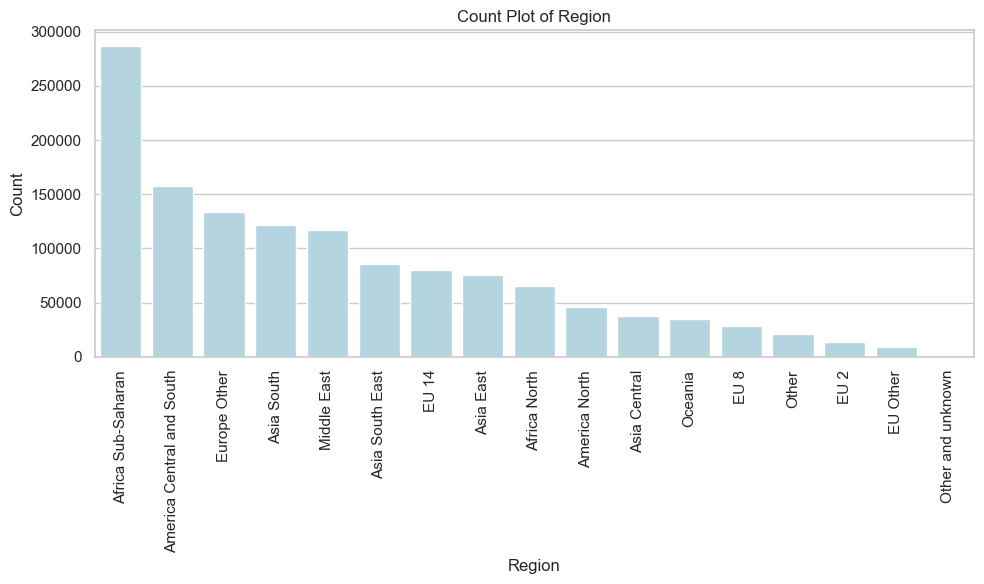

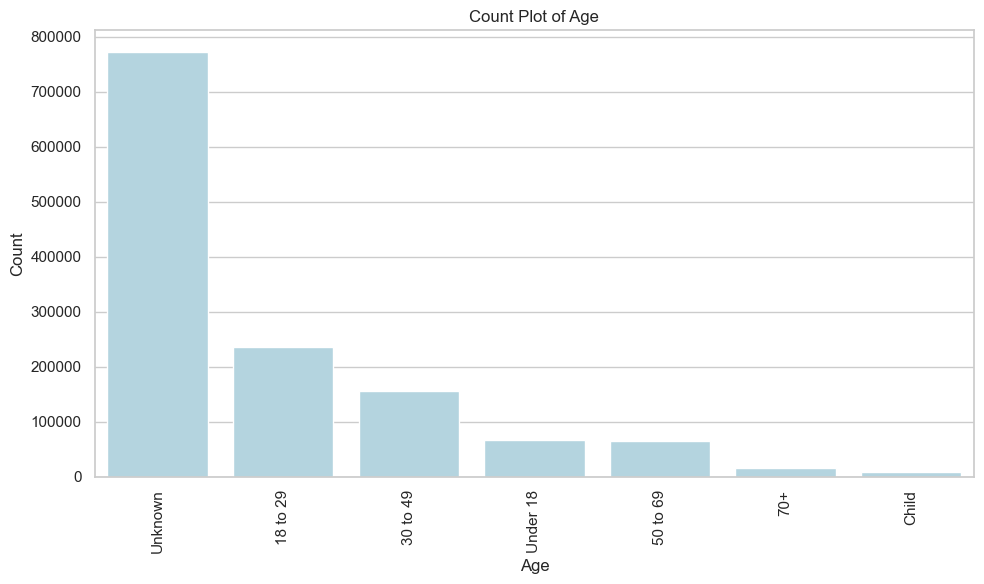

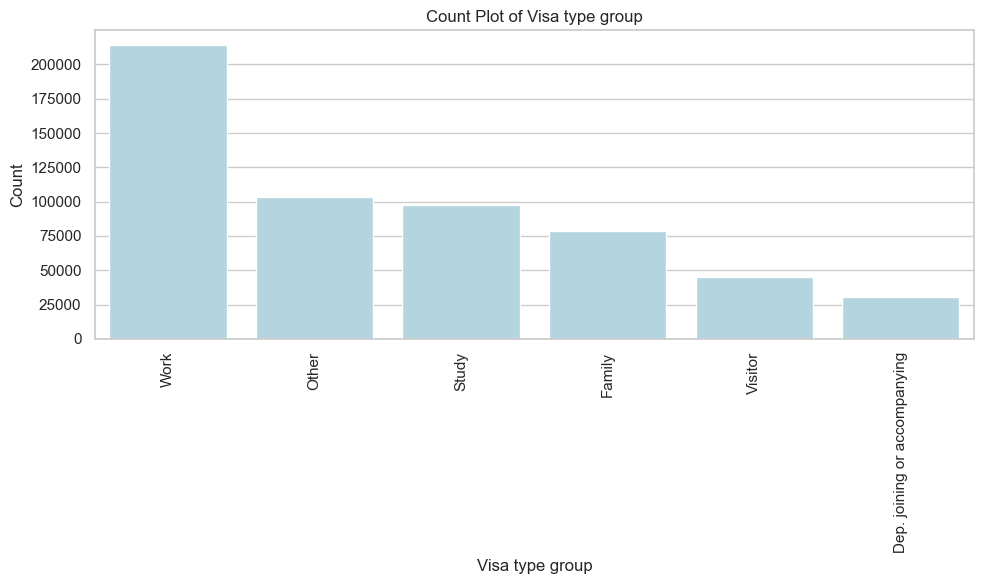

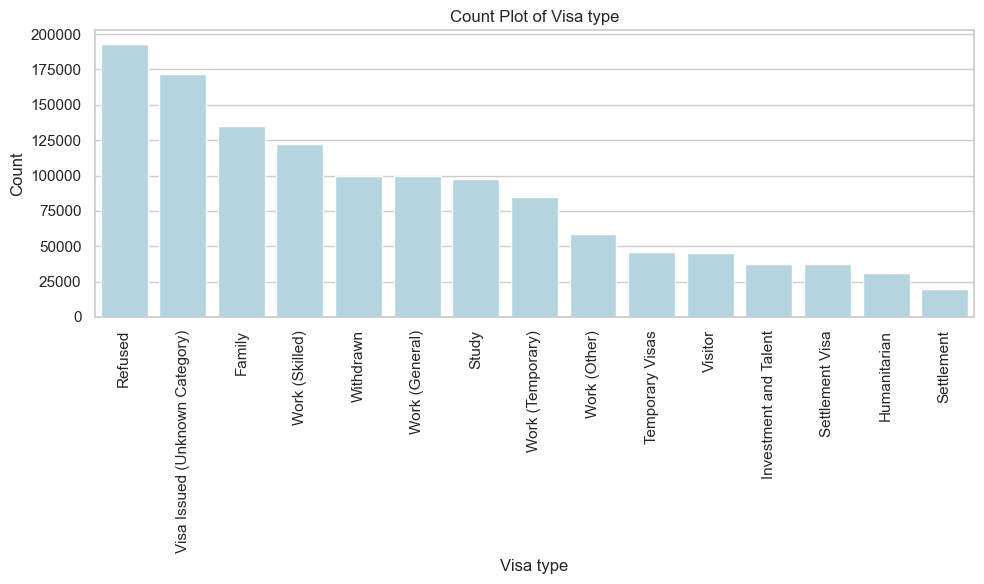

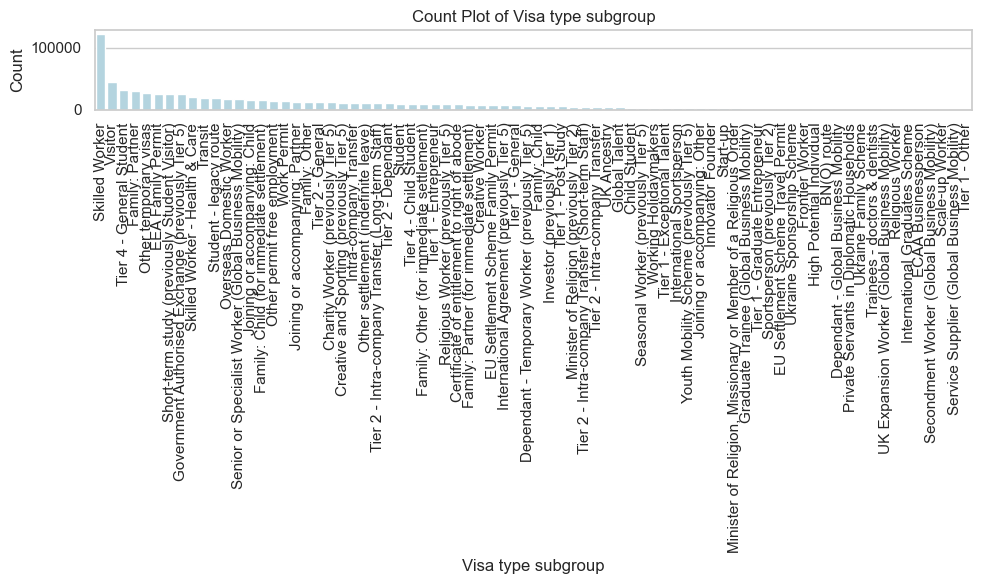

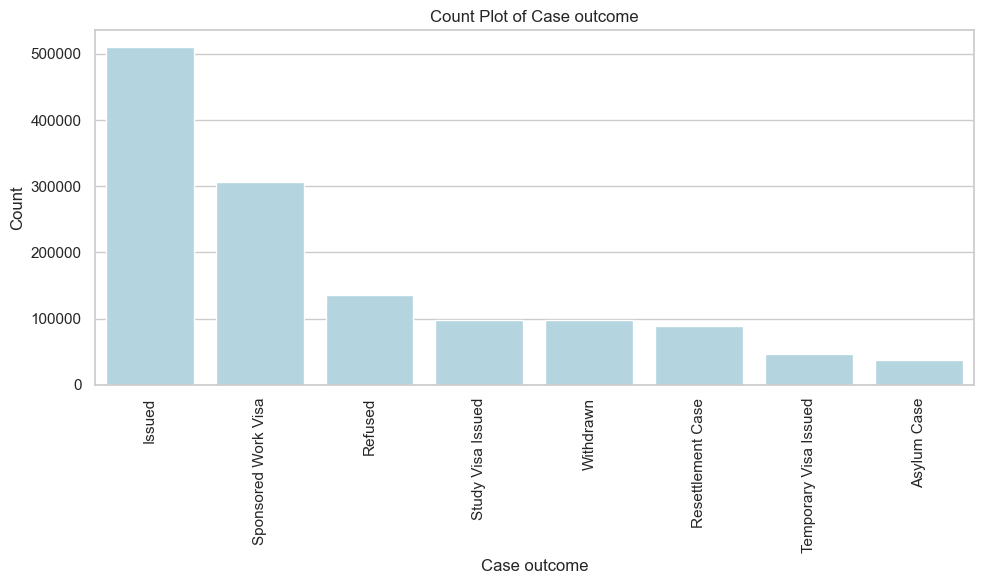

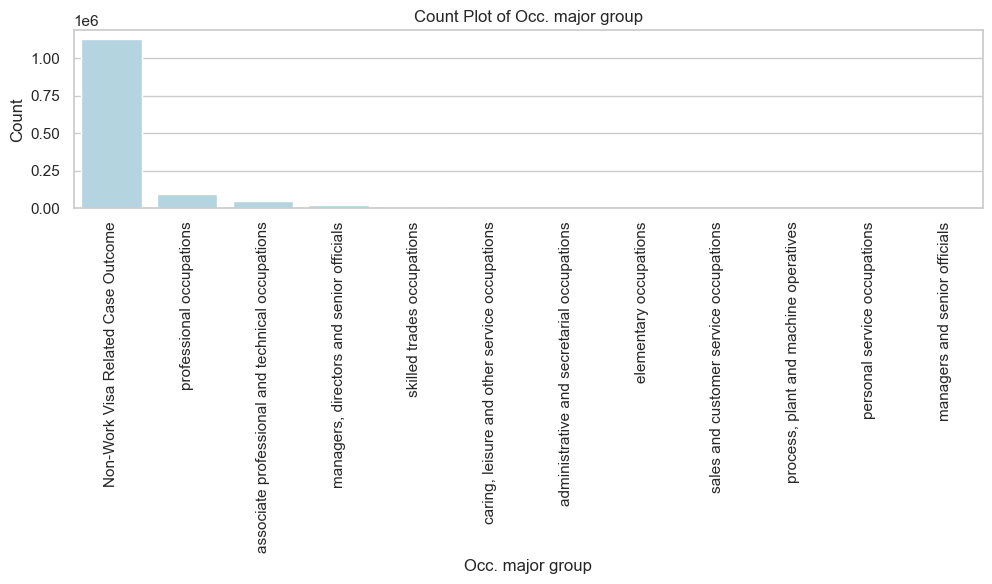

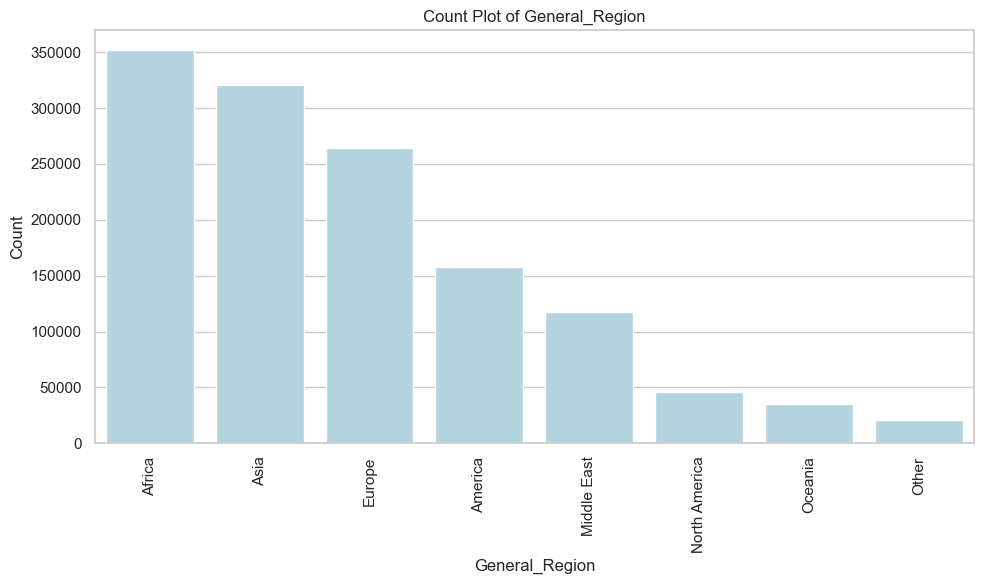

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

exclude_columns = ['Nationality', 'Occupation', 'Industry']

for col in categorical_df.columns:
    if col not in exclude_columns:
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")
        sns.countplot(data=categorical_df, x=col, order=categorical_df[col].value_counts().index, color='lightblue')
        plt.title(f'Count Plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()


Let's do a correlation matrix now

In [ ]:
corr_matrix = numeric_df.corr()

In [89]:
numeric_df.corr()

,Year,Quarter,Sex,Applications,Decisions,Grants,Total Application and Decisions
Year,1.000000,0.019815,0.160276,-0.003566,-0.006440,-0.006582,-0.006364
Quarter,0.019815,1.000000,0.008697,-0.000313,-0.001118,-0.001091,-0.001118
Sex,0.160276,0.008697,1.000000,0.027075,0.033809,0.031368,0.034109
Applications,-0.003566,-0.000313,0.027075,1.000000,0.759035,0.751102,0.759023
Decisions,-0.006440,-0.001118,0.033809,0.759035,1.000000,0.995720,0.999989
Grants,-0.006582,-0.001091,0.031368,0.751102,0.995720,1.000000,0.995729
Total Application and Decisions,-0.006364,-0.001118,0.034109,0.759023,0.999989,0.995729,1.000000


In [90]:
import pandas as pd

# Set display options
pd.set_option('display.float_format', '{:.1f}'.format)

# Now when you run describe, it should output numbers in a more readable format
numeric_df.describe()


,Year,Quarter,Sex,Applications,Decisions,Grants,Total Application and Decisions
count,1318169.0,1318169.0,1318169.0,1318169.0,1318169.0,1318169.0,1318169.0
mean,2015.2,2.5,2.5,52.5,87.3,80.4,86.7
std,5.9,1.1,0.8,1281.1,1685.9,1679.1,1685.9
min,2001.0,1.0,1.0,0.0,0.0,0.0,0.0
25%,2010.0,2.0,2.0,0.0,1.0,0.0,0.0
50%,2016.0,3.0,3.0,0.0,2.0,1.0,1.0
75%,2021.0,4.0,3.0,2.0,7.0,4.0,6.0
max,2023.0,4.0,3.0,255463.0,255463.0,255463.0,255463.0


OK this is good for now, we can probably drop Grants later, and total applications and decisions later

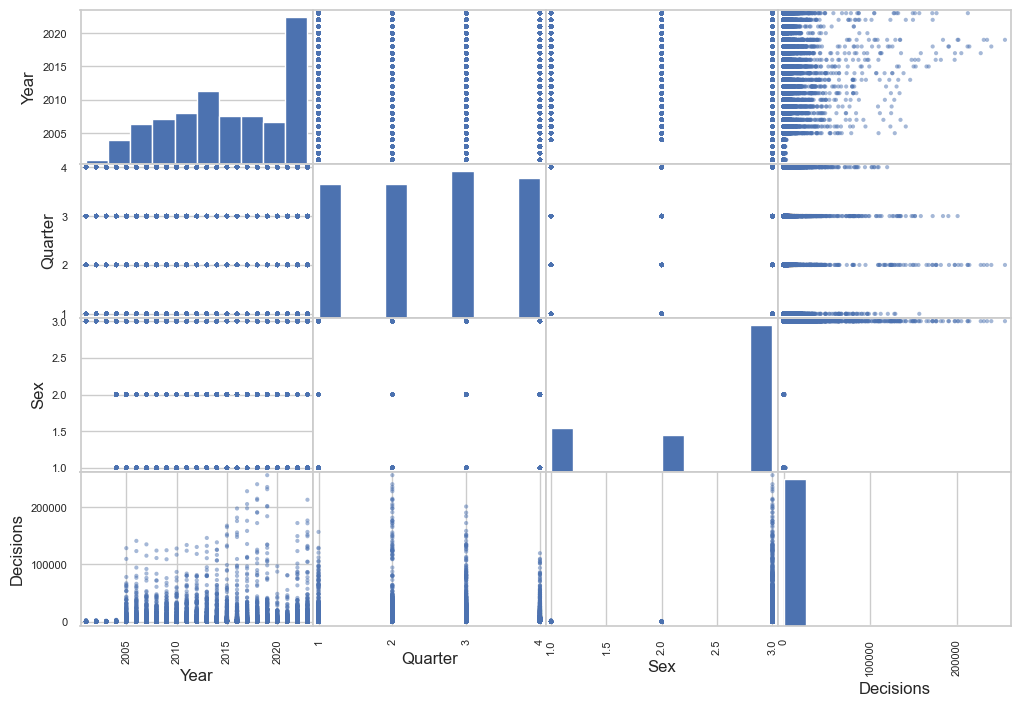

In [92]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt 

attributes = ["Year", "Quarter", "Sex", "Decisions"]
scatter_matrix(model_df[attributes], figsize=(12, 8))
plt.show()

#REF: O'Reily - Aurelien Geron book

Now we will make a boxplot for case outcome

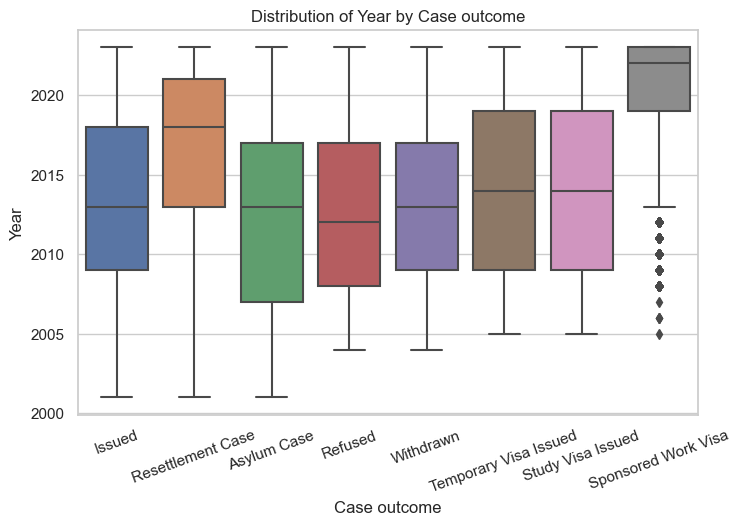

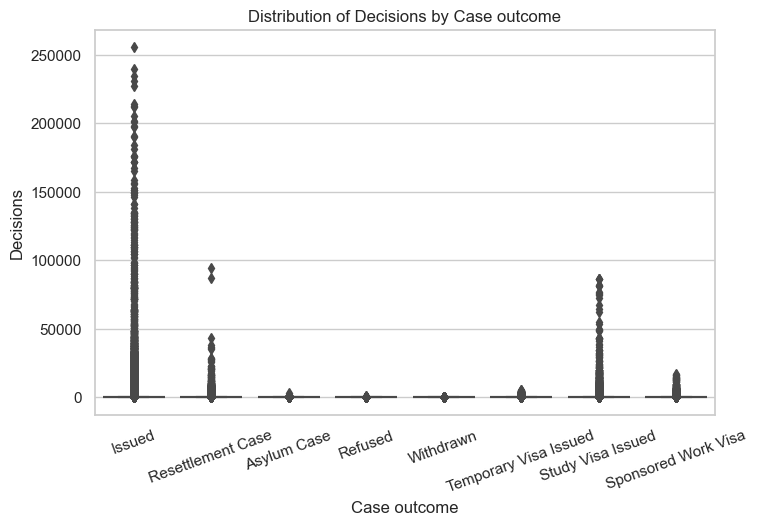

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

attributes = ["Year", "Decisions"]

for attribute in attributes:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="Case outcome", y=attribute, data=model_df)
    plt.title(f"Distribution of {attribute} by Case outcome")
    plt.xticks(rotation=20)  
    plt.show()


Later we will also experiment with feature engineering

And look at more complex models (Random Forests, SVM, KNN)

We can also include more data, would be useful to include some cost features 

Moving on to book 4!